## Univariate TS Analysis with Auto ARIMA   
In this notebook, I have tried to analysed and built a forecast model on the air passengers dataset. Below are the steps followed to perform Univariate Time Series analysis and Time Series forecasting  on the air passengers dataset.  
1. Auto-arima to find order (p,d,q) and seasonal order 
2. predict and compare on the test set
3. Build final model
4. Forecasting into future

In [1]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm

In [2]:
df=pd.read_csv('airline_passengers.csv', 
               index_col='Month',
               parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df['Passengers']=np.log(df['Passengers'])

In [4]:

import warnings
warnings.filterwarnings('ignore')

def plot_models(y_actual,y_pred):    
    """
    Method computes the RMSE and plots the y actual and y predicted
    """
    # compute RMSE
    rmse=mean_squared_error(y_actual, y_pred, squared=False)
    rmse=round(rmse,4)
    # plot
    plt.figure(figsize=(15,5)) 
    plt.plot(y_actual)
    plt.plot(y_pred, color='red')
    plt.title(f'RMSE: {rmse}')
    plt.xticks(y_actual.index[0::12], rotation ='vertical')
    plt.grid()
    plt.show()

### 1.  Auto-arima to find order

In [10]:
Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

train.tail()
model=pm.auto_arima(train['Passengers'],
                   trace=True,
                   suppress_warnings=True,
                   seasonal=True,
                   stepwise=False, 
                   n_jobs=1,
                   m=12)
model.summary()

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-317.949, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-327.548, Time=0.20 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-330.762, Time=0.48 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-323.065, Time=0.25 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-323.589, Time=0.56 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-324.758, Time=1.11 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=-330.543, Time=1.48 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-365.384, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-383.189, Time=0.29 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-384.619, Time=1.41 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-375.325, Time=0.55 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-384.239, Time=0.80 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 229.026
Date:                              Sun, 15 Jan 2023   AIC                           -448.052
Time:                                      15:38:36   BIC                           -434.114
Sample:                                  01-01-1949   HQIC                          -442.392
                                       - 12-01-1959                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0193      0.009      2.155      0.031       0.002       0.037
ar.L1          0.6004      0.083      7.273      0.000       0.439       0.762
ar.L2          0.2415      0.085      2.851      0.004       0.076       0.408
ma.S.L12      -0.5668      0.105     -5.411      0.000      -0.772      -0.361
sigma2         0.0012      0.000      8.190      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.09
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.36   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

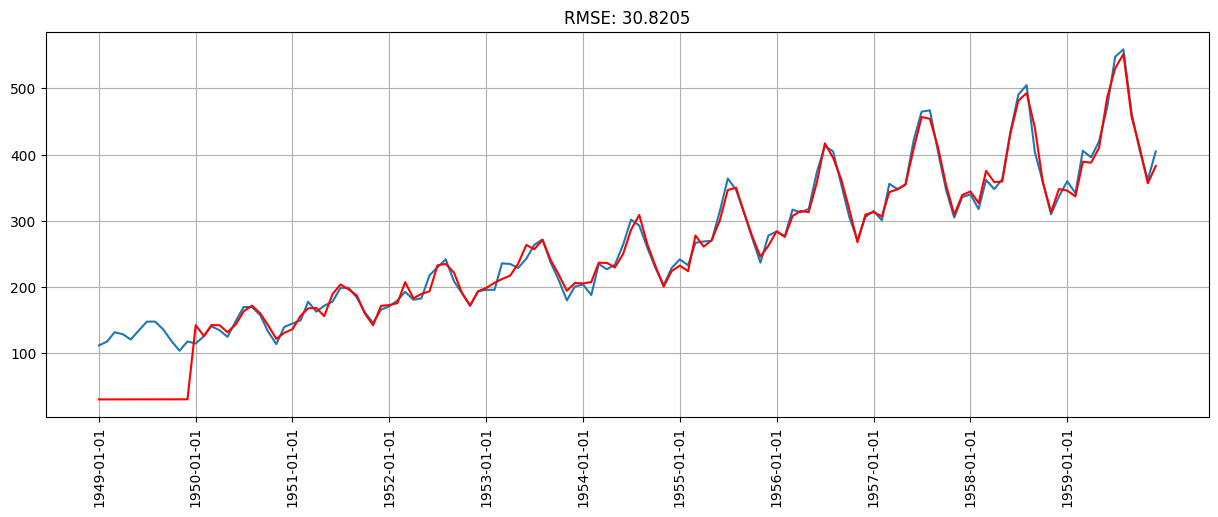

In [7]:
train_pred=model.predict_in_sample(start=0, end=-1)

# check the model fit with the train data
plot_models(y_actual=train['Passengers'],y_pred=train_pred)

### 2. predict and compare on the test set

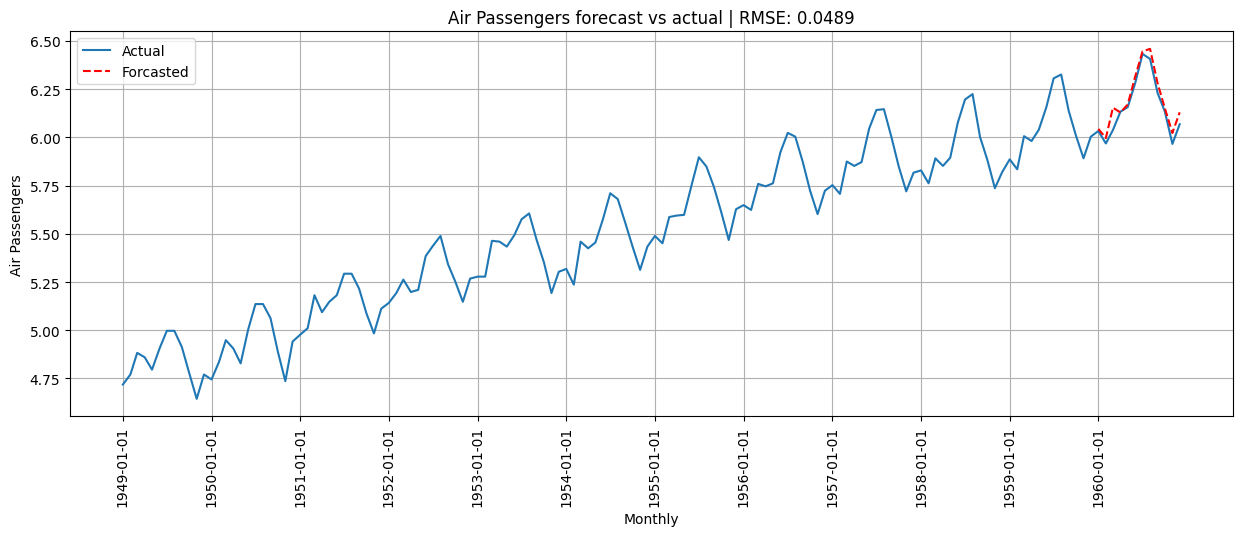

In [8]:
test_pred, confint=model.predict(n_periods=12, return_conf_int=True)
rmse=mean_squared_error(test, test_pred, squared=False)
rmse=round(rmse,4)

final=pd.Series(df['Passengers'], index=df.index)
final=final.add(test_pred, fill_value=0)


# plot test actual vs test predicted
plt.figure(figsize=(15,5)) 
plt.plot(df[['Passengers']], label='Actual')
plt.plot(test_pred, color='red', label='Forcasted',linestyle="--")

plt.xticks(final.index[0::12], rotation ='vertical')
plt.legend(loc="upper left")
plt.xlabel("Monthly")
plt.ylabel("Air Passengers")
plt.title(f"Air Passengers forecast vs actual | RMSE: {rmse}")

plt.grid()
plt.show()

### 3. Building the final model


In [12]:
# Train on full data with best params from auto arima
model= pm.arima.ARIMA(order=(3,0,0), 
                      seasonal_order=(0,1,0,12),
                      suppress_warnings=True).fit(df['Passengers'])

### 4. Forecasting into future

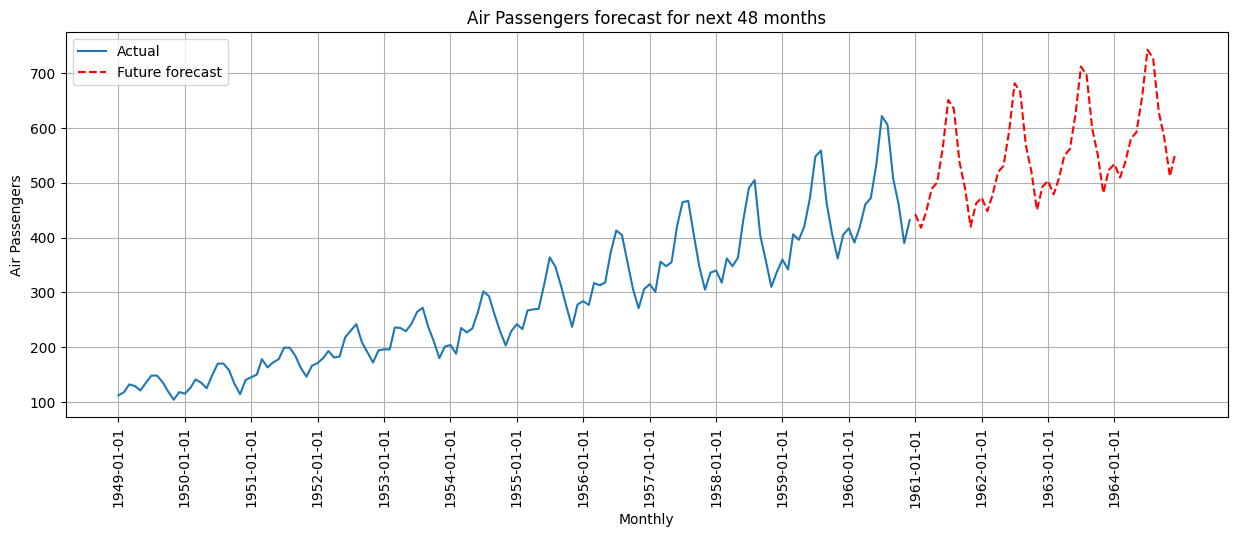

In [16]:
# Future forecast
steps=48 # months

y_pred=model.predict(n_periods=steps)
final=pd.Series(df['Passengers'], index=df.index)
final=final.add(y_pred, fill_value=0)

# plot
plt.figure(figsize=(15,5)) 
plt.plot(final[:-steps], label='Actual')
plt.plot(final[-steps:], color='red', linestyle="--", label='Future forecast')
plt.xticks(final.index[0::12], rotation ='vertical')
plt.legend(loc="upper left")
plt.xlabel("Monthly")
plt.ylabel("Air Passengers")
plt.title("Air Passengers forecast for next 48 months")
plt.grid()
plt.show()